In [3]:
using Pkg
Pkg.clone("https://github.com/pnavaro/Splittings.jl.git")

  Updating git-repo `https://github.com/pnavaro/Splittings.jl.git`


┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:463


 Resolving package versions...


┌ Info: Path `/Users/navaro/.julia/dev/Splittings` exists and looks like the correct package, using existing path instead of cloning
└ @ Pkg.Types /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Pkg/src/Types.jl:586


  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [4]:
using LinearAlgebra, QuadGK, Roots, FFTW, BenchmarkTools

In [14]:
using Splittings

In [15]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [16]:
" Compute M₀ by solving F(m) = 0 "
function mag(β, mass)
    
    F(m) = begin
        g(x, n, m) = (1 / π) * (exp(β * m * cos(x)) * cos(n * x))
        bessel0(x) = g(x, 0, m) 
        bessel1(x) = g(x, 1, m)
        mass * quadgk(bessel1, 0, π)[1] / quadgk(bessel0, 0, π)[1] - m
    end
    
    find_zero(F, (0, mass))
end

mag

In [17]:
function Norm(f::Array{Float64,2}, dx, dv)
   return dx * sum(dv * sum(real(f), dims=1))
end

Norm (generic function with 1 method)

In [18]:
"""
    Compute the electric hamiltonian mean field from a 
    2D distribution function
"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2}, 
        meshx::UniformMesh, 
        meshv::UniformMesh,
        ex::Array{Float64})

    nx = meshx.nx
    rho = meshv.dx .* vec(sum(fᵗ, dims=1))
    kernel = zeros(Float64, nx)
    k = π / (meshx.xmax - meshx.xmin)
    kernel[2] = k
    ex .= real(ifft(1im * fft(rho) .* kernel * 4π ))

end

hmf_poisson!

In [19]:
function bsl_advection!(f::Array{Complex{Float64},2},
                        meshx::UniformMesh, 
                        meshv::UniformMesh,
                        v::Array{Float64,1},
                        dt;
                        spline_degree=3)
    
    fft!(f,1)
    @simd for j in 1:meshv.nx
        alpha = v[j] * dt
        @inbounds f[:,j] .= Splittings.interpolate(spline_degree, f[:,j], 
            meshx.dx, alpha)
    end
    ifft!(f,1)
end

bsl_advection! (generic function with 1 method)

In [21]:
function push_v!(f, fᵗ, meshx, meshv, ex, dt)
    transpose!(fᵗ, f)
    hmf_poisson!(fᵗ, meshx, meshv, ex)
    bsl_advection!(fᵗ, meshv, meshx, ex, dt)
    transpose!(f, fᵗ)
end

push_v! (generic function with 1 method)

In [24]:
function vlasov_hmf_gauss(nbiter = 10000, dt = 0.1)

    mass = 1.0
    T = 0.1
    meshx = UniformMesh(-π, π, 64)
    meshv = UniformMesh(-8, 8, 64)
    
    nx, dx = meshx.nx, meshx.dx
    nv, dv = meshv.nx, meshv.dx
    x, v = meshx.x, meshv.x
    X = repeat(x,1,nv)
    V = repeat(v,1,nx)'
    ϵ = 0.1
    
    b = 1 / T
    m = mag(b, mass)
   
    w   = sqrt(m)
    f   = zeros(Complex{Float64}, (nx,nv))
    fᵗ  = zeros(Complex{Float64}, (nv,nx))
    
    f  .= exp.(-b .* ((V.^2 / 2) - m * cos.(X)))
    a   = mass / Norm(real(f), dx, dv)
    @.  f =  a * exp(-b * (((V^2) / 2) - m * cos(X))) * (1 + ϵ * cos(X))
    
    ex = zeros(Float64,nx)
    hmf_poisson!(f, meshx, meshv, ex )
    test = copy(f)
    T = Float64[]
    for n in 1:nbiter
    
        gamma1 = Norm(real(f) .* cos.(X), dx, dv)
        push!(T,gamma1)
    
        @Strang(
            bsl_advection!(f, meshx, meshv, v, dt),
            push_v!(f, fᵗ, meshx, meshv, ex, dt)
        )
    
    end
    
    #Substracting from gamma its long time average
    
    Gamma1 = Norm(real(f) .*cos.(X), dx, dv)
    T .= T .- Gamma1
    
    range(0., stop=nbiter*deltat, length=nbiter), abs.(T)
    
end 

vlasov_hmf_gauss (generic function with 3 methods)

In [27]:
nbiter = 2000
deltat = 0.1
@time t, T = vlasov_hmf_gauss(nbiter, deltat);

  4.121293 seconds (3.49 M allocations: 2.324 GiB, 4.69% gc time)


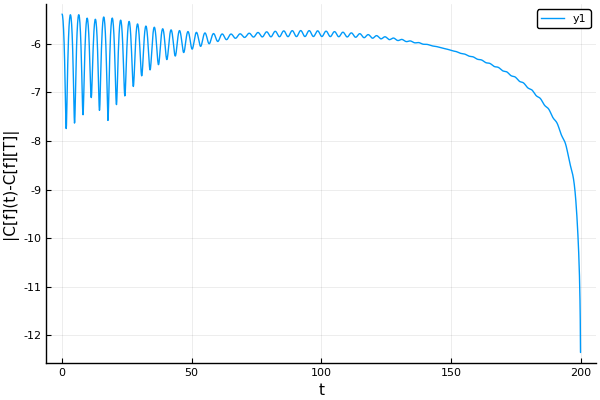

In [28]:
plot(t, log.(T), 
    xlabel = "t",
    ylabel = "|C[f](t)-C[f][T]|")